# 한강 인근 여부와 한강 및 지천 생활권 여부

> 한강 인근 여부와 한강 및 지천 생환권 여부를 파악하기
> - 한강 인근 여부 : 동단위로 임의적으로 포함 -> 향후 데이터로 보완
> - 한강 및 지천 생활권 여부 : 외부 데이터 사용

## Contents
- 1. 한강 인근 여부만 확인
- 2. 한강 인근 여부 + 한강 및 지천 생활권 여부 확인
- 3. 한강 및 지천 생활권 여부만 확인

## 라이브러리 불러오기

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.font_manager as fm
import seaborn as sns

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

## 데이터 불러오기

In [2]:
data = pd.read_csv('../train_lon_apt.csv', index_col=0)
data.head()

/tmp/ipykernel_371235/2836755354.py:1: DtypeWarning: Columns (14,15,16,17,18,20,21,22,23,26,27,28,36,37,38,39,40,41,42,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../train_lon_apt.csv', index_col=0)


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,123500.0,0,서울특별시 강남구 개포동 658-1
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,91500.0,0,서울특별시 강남구 개포동 658-1
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,130000.0,0,서울특별시 강남구 개포동 658-1
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,117000.0,0,서울특별시 강남구 개포동 658-1


In [3]:
gdf_seoul = gpd.read_file('../geo/LARD_ADM_SECT_SGG_11_202403.shp', encoding='cp949')
gdf_seoul = gdf_seoul.to_crs(epsg=4326)
gdf_seoul.head()

,ADM_SECT_C,SGG_NM,SGG_OID,COL_ADM_SE,geometry
0,11110,종로구,11,11110,"POLYGON ((126.97448 37.63425, 126.97526 37.634..."
1,11140,중구,34,11140,"POLYGON ((126.99072 37.57035, 126.99095 37.570..."
2,11170,용산구,1,11170,"POLYGON ((126.94539 37.53600, 126.94541 37.536..."
3,11200,성동구,1,11200,"POLYGON ((127.02758 37.56726, 127.02729 37.567..."
4,11215,광진구,49,11215,"POLYGON ((127.07772 37.52474, 127.07510 37.525..."


## 1. 한강 인근 여부만 확인

In [9]:
target_dongs = [
    # 강남구
    "논현동", "청담동", "삼성동", "압구정동", "신사동", # 대치 ?
    # 용산구
    "원효로1가", "원효로2가", "원효로3가", "원효로4가",
    "이촌동", "서빙고동", "한남동", "동빙고동", "보광동", "이태원동", "용문동", "효창동", "산청동", "용산동2가",
    "한강로1가", "한강로2가", "한강로3가",
    # 영등포구
    "여의도동", "당산동", "양평동1가", "양평동2가", "양평동3가", "양평동4가", "양평동5가", "양평동6가",
    "당산동1가", "당산동2가", "당산동3가", "당산동4가", "당산동5가", "당산동6가",
    # "영등포동1가", "영등포동2가", "영등포동3가", "영등포동4가", "영등포동5가", "영등포동6가", "영등포동7가", "영등포동8가",
    # 강서구
    "가양동", "방화동", "염창동", "등촌동", '마곡동',
    # 마포구
    "망원동", "합정동", "연남동", "성산동", "서교동", "신수동", "상수동", "용강동", "도화동", "창전동", "토정동", "현석동",
    "신정동", "하중동", "구수동", "상암동",
    # 서초구
    "반포동", "잠원동",
    # 송파구
    "잠실동", "신천동", "풍납동", "방이동",
    # 양천구
    "목동", 
    # 성동구
    "옥수동", "금호동", "성수동1가", "성수동2가", "금호동1가", "금호동2가", "금호동3가", "금호동4가",
    # 광진구
    "구의동", "자양동", "광장동",
    # 강동구
    "천호동", "암사동", "고덕동",
    # 동작구
    "노량진동", "본동", "흑석동"
]

# '시군구' 칼럼을 공백을 기준으로 분할하여 새로운 칼럼에 할당
data[['시', '구', '동']] = data['시군구'].str.split(' ', expand=True)

# '한강 인근' 칼럼을 조정하여 은평구의 신사동과 양천구의 신정동은 '한강 인근'에서 제외하는 조건을 추가
data['한강 인근'] = data.apply(
    lambda row: 1 if (row['동'] in target_dongs and not ((row['구'] == '은평구' and row['동'] == '신사동') or (row['구'] == '양천구' and row['동'] == '신정동'))) else 0, axis=1
)

# 결과 확인
data[['구', '동', '한강 인근']]

,구,동,한강 인근
0,강남구,개포동,0
1,강남구,개포동,0
2,강남구,개포동,0
3,강남구,개포동,0
4,강남구,개포동,0
...,...,...,...
1128089,중랑구,신내동,0
1128090,중랑구,신내동,0
1128091,중랑구,신내동,0
1128092,중랑구,중화동,0


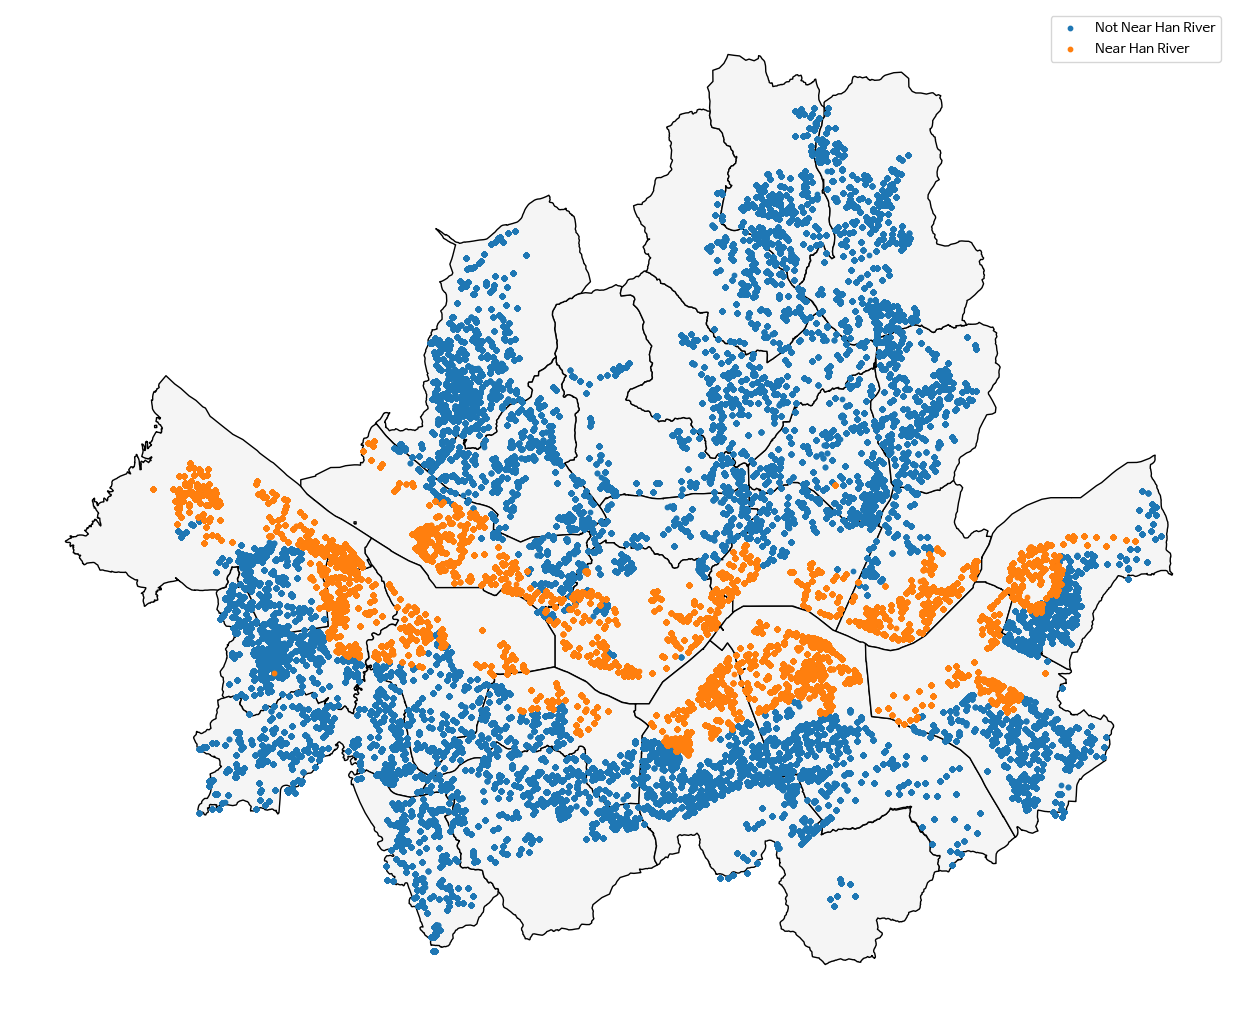

In [10]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)

# 서울 지도를 배경으로 그립니다.
gdf_seoul.plot(color='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

# '한강 인근' 칼럼에 따라 그룹화하여 시각화
for is_near_han_river, group in data.groupby('한강 인근'):
    label = 'Near Han River' if is_near_han_river == 1 else 'Not Near Han River'
    ax.scatter(group['좌표X'], group['좌표Y'], label=label, s=10)

# 레전드 추가
ax.legend()
ax.set_axis_off()
plt.show()

In [11]:
near_hangang = data[data['한강 인근'] == 1]
not_near_hangang = data[data['한강 인근'] == 0]

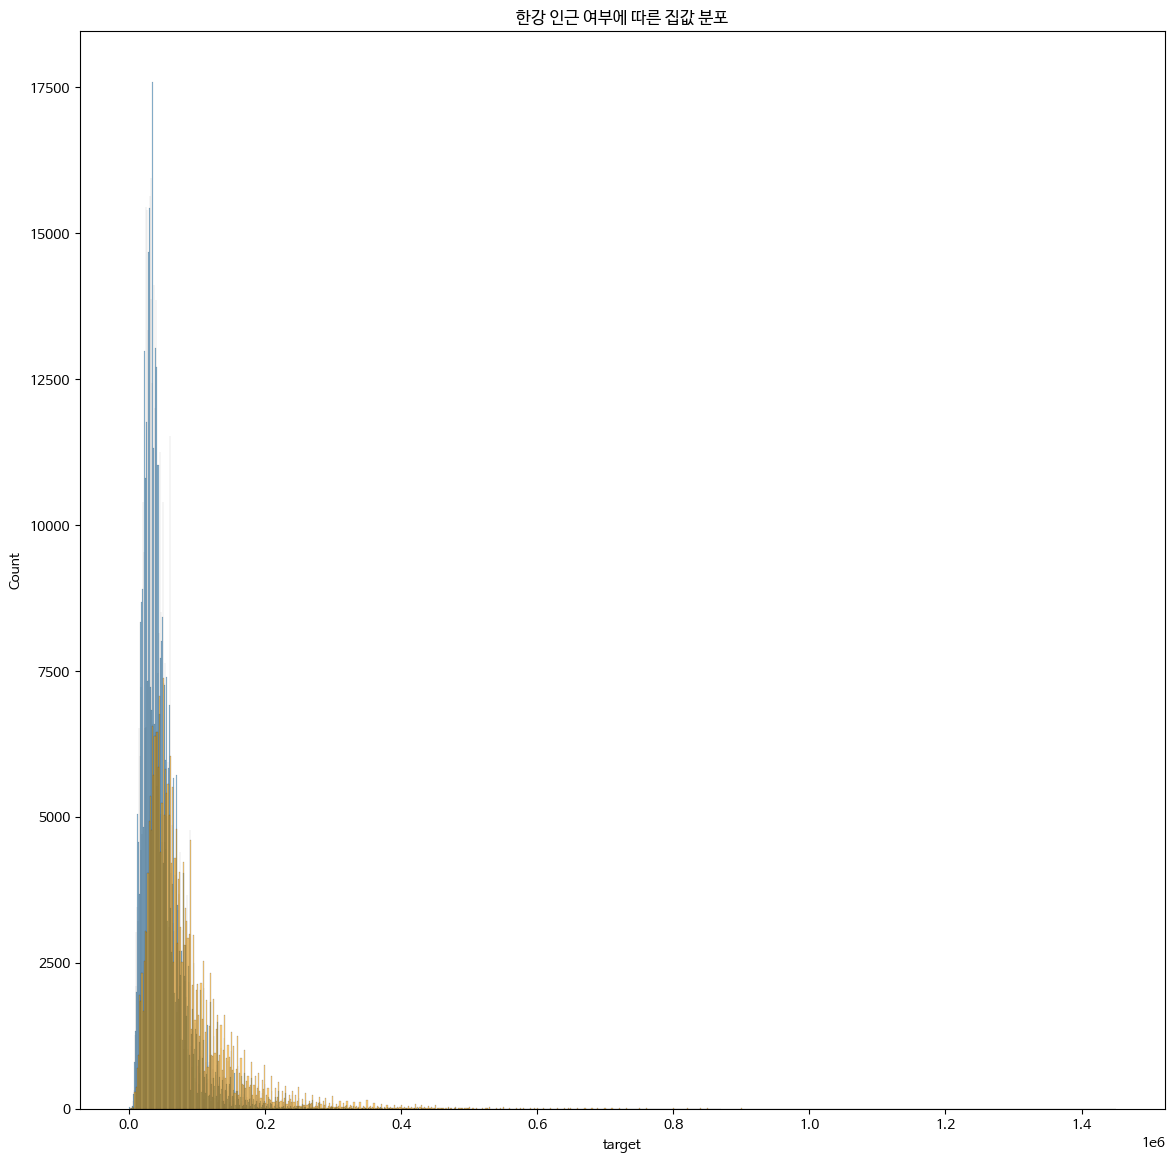

In [12]:
plt.figure(figsize=(14,14))
sns.histplot(data=not_near_hangang, x='target', alpha=0.5)
sns.histplot(data=near_hangang, x='target', color='orange', alpha=0.5)
plt.title("한강 인근 여부에 따른 집값 분포")
plt.show()

## 2. 한강 인근 여부 + 한강 및 지천 생활권 여부

In [13]:
hangang_per_apt = pd.read_csv('../3_서울시 아파트별 한강 및 지천 생활권 정보.csv', encoding='cp949')
hangang_per_apt

,시군구코드,법정동코드,단지코드,단지명,세대수,법정동주소,코스수,코스총길이,생활지수,생활지수명,평가점수
0,11110,1111011500,A11005401,광화문풍림스페이스본 아파트,744,서울특별시 종로구 사직동 9 광화문풍림스페이스본 아파트,0,0.00,5,하위권,0
1,11110,1111011800,A11007001,경희궁의아침3단지,150,서울특별시 종로구 내수동 72 경희궁의아침3단지,1,8179.50,4,중하위권,84
2,11110,1111011800,A11087101,경희궁의아침2단지,90,서울특별시 종로구 내수동 71 경희궁의아침2단지,1,8179.50,4,중하위권,84
3,11110,1111012400,A11014001,로얄팰리스스위트,23,서울특별시 종로구 수송동 85 로얄팰리스스위트,1,8179.50,4,중하위권,84
4,11110,1111013300,A11034001,현대뜨레비앙,291,서울특별시 종로구 익선동 55 현대뜨레비앙,1,8179.50,4,중하위권,84
...,...,...,...,...,...,...,...,...,...,...,...
2638,11740,1174011000,A13410006,강일리버파크4단지,748,서울특별시 강동구 강일동 673 강일리버파크4단지,2,8064.31,4,중하위권,84
2639,11740,1174011000,A13410004,강일리버파크6단지,553,서울특별시 강동구 강일동 684 강일리버파크6단지,2,8064.31,4,중하위권,84
2640,11740,1174011000,A13410010,강일리버파크7단지,731,서울특별시 강동구 강일동 686 강일리버파크7단지,2,8064.31,4,중하위권,84
2641,11740,1174011000,A13410009,강일리버파크5단지,722,서울특별시 강동구 강일동 670 강일리버파크5단지,2,8064.31,4,중하위권,84


In [14]:
# '법정동주소'를 공백으로 분할
address_parts = hangang_per_apt['법정동주소'].str.split(' ', expand=True)
hangang_per_apt['시'] = address_parts[0]
hangang_per_apt['구'] = address_parts[1]
hangang_per_apt['동'] = address_parts[2]
hangang_per_apt['번지'] = address_parts[3]

# 결과 확인
hangang_per_apt[['시', '구', '동', '번지', '단지명']]

,시,구,동,번지,단지명
0,서울특별시,종로구,사직동,9,광화문풍림스페이스본 아파트
1,서울특별시,종로구,내수동,72,경희궁의아침3단지
2,서울특별시,종로구,내수동,71,경희궁의아침2단지
3,서울특별시,종로구,수송동,85,로얄팰리스스위트
4,서울특별시,종로구,익선동,55,현대뜨레비앙
...,...,...,...,...,...
2638,서울특별시,강동구,강일동,673,강일리버파크4단지
2639,서울특별시,강동구,강일동,684,강일리버파크6단지
2640,서울특별시,강동구,강일동,686,강일리버파크7단지
2641,서울특별시,강동구,강일동,670,강일리버파크5단지


In [15]:
# 아파트명 추출
unique_apt_names = hangang_per_apt['단지명'].unique().tolist()
print(unique_apt_names)

['광화문풍림스페이스본 아파트', '경희궁의아침3단지', '경희궁의아침2단지', '로얄팰리스스위트', '현대뜨레비앙', '효성주얼리시티아파트', '포레스트힐시티', '명륜아남1차', '창신쌍용1단지', '창신두산', '창신쌍용아파트 2단지', '종로청계힐스테이트', '롯데캐슬천지인', '종로센트레빌', '숭인상가아파트', '경희궁자이4단지주상복합', '경희궁자이3단지', '경희궁자이2단지 아파트', '경희궁자이1단지(임대아파트)', '동익빌라', '평창삼성', '평창롯데', '금강주택', '무악현대', '무악현대임대', '인왕산아이파크', '인왕산2차아이파크아파트', '경희궁 롯데캐슬아파트', '남산SK리더스뷰', '남산롯데캐슬아이리스', '쌍용남산플래티넘', '충무로진양', '남산센트럴자이', '충무로엘크루메트로시티2', '인현신성', '묵정아파트', '신당삼성(분양)', '신당삼성임대', '신당현대', '신당남산타운(분양)', '신당약수하이츠', '신당푸르지오', '약수하이츠아파트(임대)', '래미안신당하이베르', '래미안신당하이베르임대', '신당남산타운임대', '청구e편한세상임대', '파라다이스', '청구e편한세상(분양)', '하왕한진그랑빌', '신당 파인힐 하나유보라', '신당KCC스위첸아파트', '동대문와이즈캐슬', '청계천두산위브더제니스', '롯데캐슬베네치아', 'SH황학롯데캐슬베네치아', '황학아크로타워', '황학코아루', '순화동포스코더샵', '중림삼성래미안아파트', '중림삼성사이버빌리지', 'LIG서울역리가', '서울역한라비발디센트럴아파트', '서울역센트럴자이아파트', '후암미주', '동부센트레빌아스테리움서울', '리첸시아용산', '용산더프라임', '신창세방리버하이빌', '한강타운', '리버힐삼성아파트', '산천리버힐제2', '청암자이', '원효산호', '원효로강변삼성스위트', '효창파크푸르지오', '용산롯데캐슬센터포레아파트', '용산kcc스위첸', '도원삼성래미안', '도원삼성제2', '브라운스톤용산', '용산CJ나인파크', '이안용산프리미어

In [16]:
# tqdm을 사용하여 진행 상태 표시
for apt_name in tqdm(unique_apt_names):
    data.loc[data['아파트명'] == apt_name, '한강 인근'] = 1

  0%|          | 0/2634 [00:00<?, ?it/s]

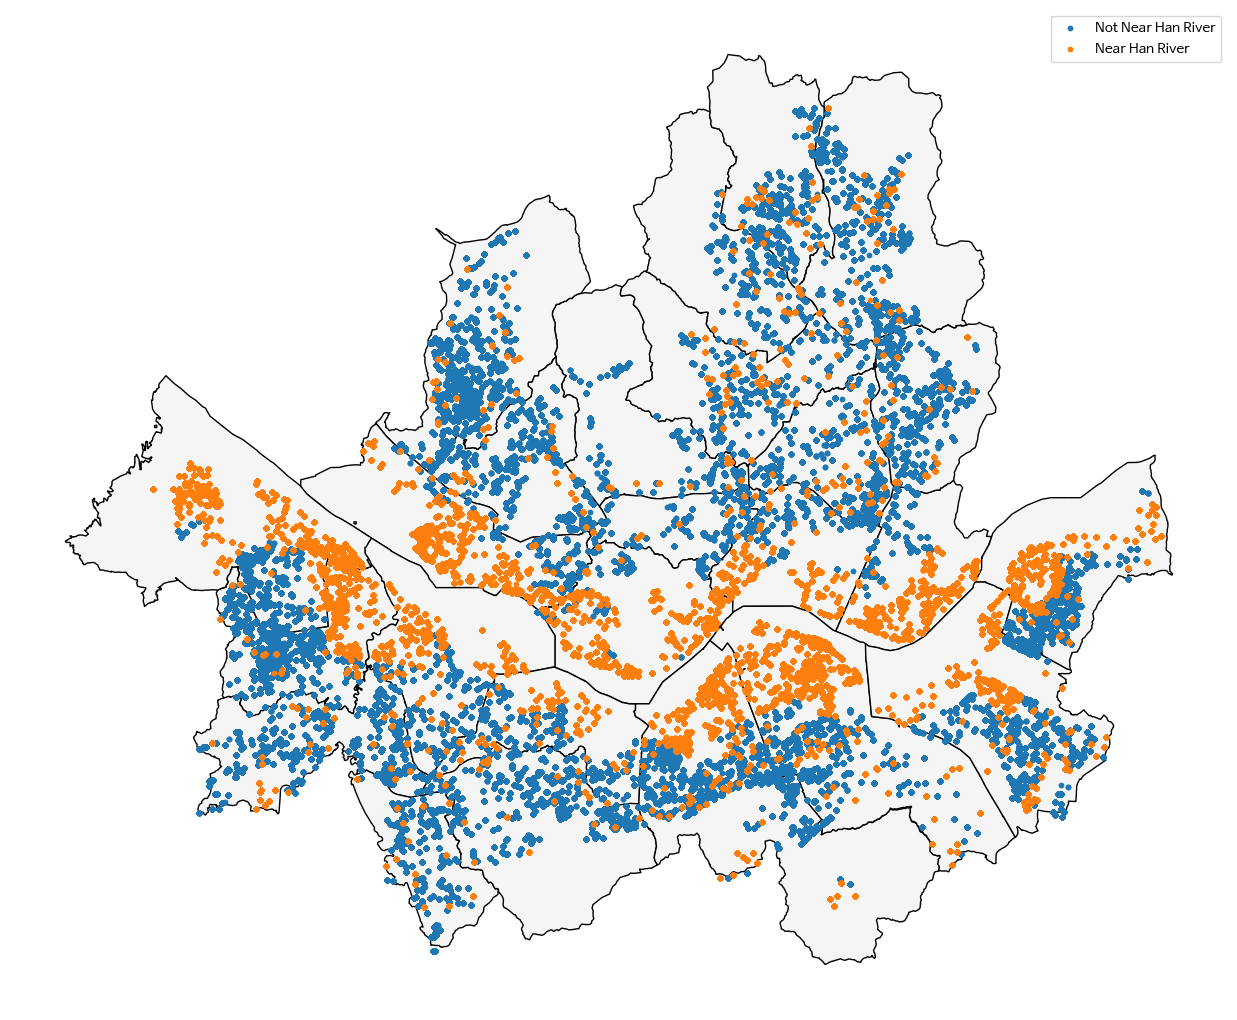

In [17]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)

# 서울 지도를 배경으로 그립니다.
gdf_seoul.plot(color='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

# '한강 인근' 칼럼에 따라 그룹화하여 시각화
for is_near_han_river, group in data.groupby('한강 인근'):
    label = 'Near Han River' if is_near_han_river == 1 else 'Not Near Han River'
    ax.scatter(group['좌표X'], group['좌표Y'], label=label, s=10)

# 레전드 추가
ax.legend()

ax.set_axis_off()
plt.show()

In [19]:
near_hangang = data[data['한강 인근'] == 1]
not_near_hangang = data[data['한강 인근'] == 0]

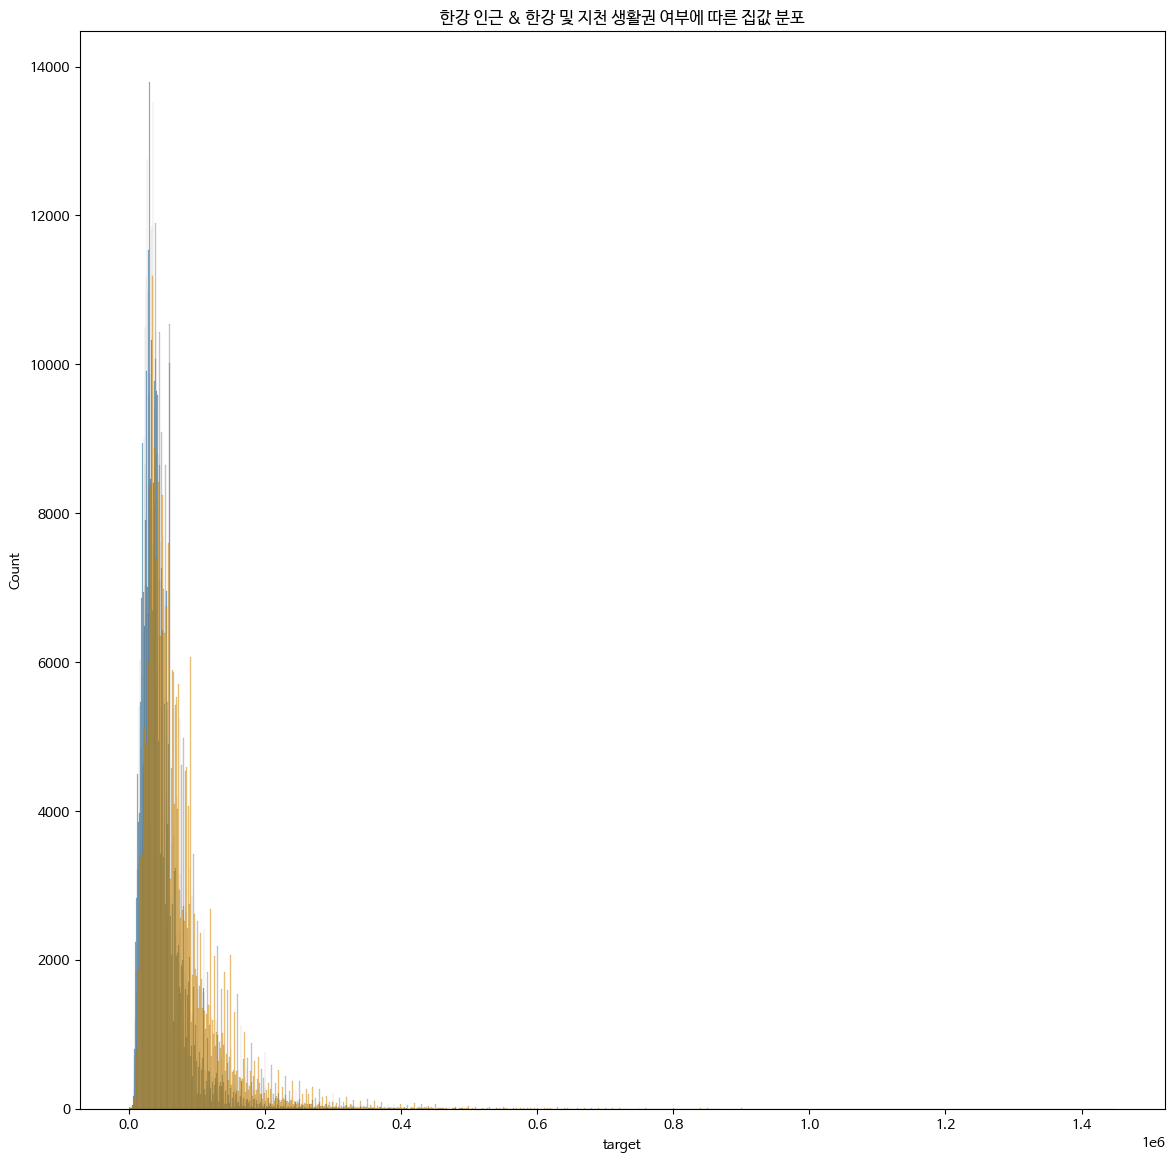

In [20]:
plt.figure(figsize=(14,14))
sns.histplot(data=not_near_hangang, x='target', alpha=0.5)
sns.histplot(data=near_hangang, x='target', color='orange', alpha=0.5)
plt.title("한강 인근 & 한강 및 지천 생활권 여부에 따른 집값 분포")
plt.show()

## 3. 한강 및 지천 생활권 여부만

In [22]:
new_data = pd.read_csv('../train_lon_apt.csv', index_col=0)
new_data.head()

/tmp/ipykernel_371235/2545028708.py:1: DtypeWarning: Columns (14,15,16,17,18,20,21,22,23,26,27,28,36,37,38,39,40,41,42,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  new_data = pd.read_csv('../train_lon_apt.csv', index_col=0)


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,지번주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,124000.0,0,서울특별시 강남구 개포동 658-1
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,123500.0,0,서울특별시 강남구 개포동 658-1
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,91500.0,0,서울특별시 강남구 개포동 658-1
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,130000.0,0,서울특별시 강남구 개포동 658-1
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,개포6차우성,117000.0,0,서울특별시 강남구 개포동 658-1


In [23]:
# '한강 및 지천 생활권 여부' 칼럼을 0으로 초기화
new_data['한강 및 지천 생활권 여부'] = 0

# tqdm을 사용하여 진행 상태를 표시하면서 '아파트명'이 unique_apt_names에 있는 경우만 1로 업데이트
for apt_name in tqdm(unique_apt_names):
    new_data.loc[new_data['아파트명'] == apt_name, '한강 및 지천 생활권 여부'] = 1

  0%|          | 0/2634 [00:00<?, ?it/s]

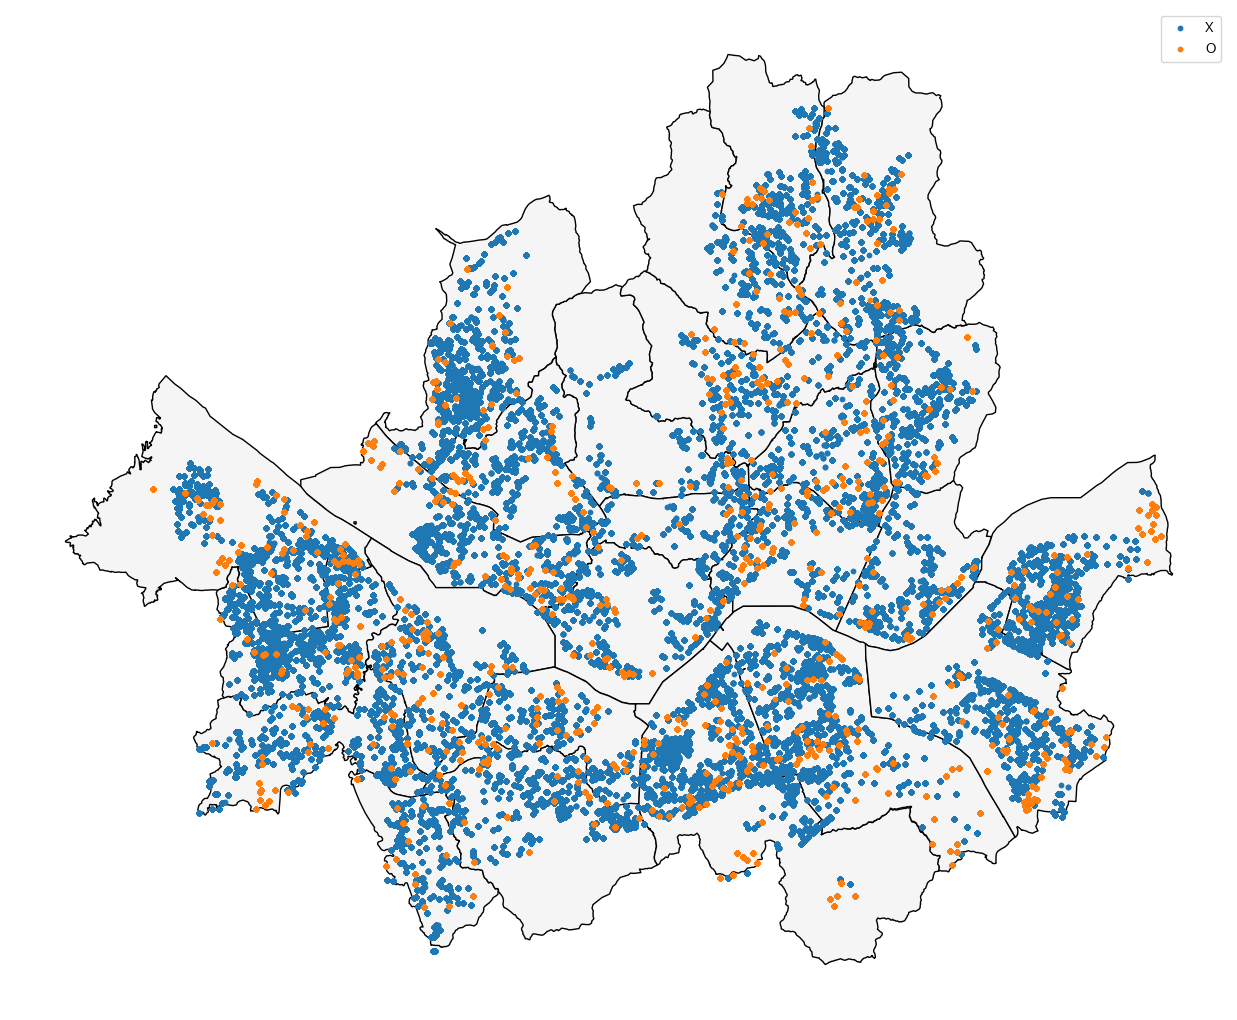

In [24]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)

# 서울 지도를 배경으로 그립니다.
gdf_seoul.plot(color='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

# '한강 인근' 칼럼에 따라 그룹화하여 시각화
for is_near_han_river, group in new_data.groupby('한강 및 지천 생활권 여부'):
    label = 'O' if is_near_han_river == 1 else 'X'
    ax.scatter(group['좌표X'], group['좌표Y'], label=label, s=10)

# 레전드 추가
ax.legend()

ax.set_axis_off()
plt.show()

In [25]:
near_hangang_a = new_data[new_data['한강 및 지천 생활권 여부'] == 1]
not_near_hangang_a = new_data[new_data['한강 및 지천 생활권 여부'] == 0]

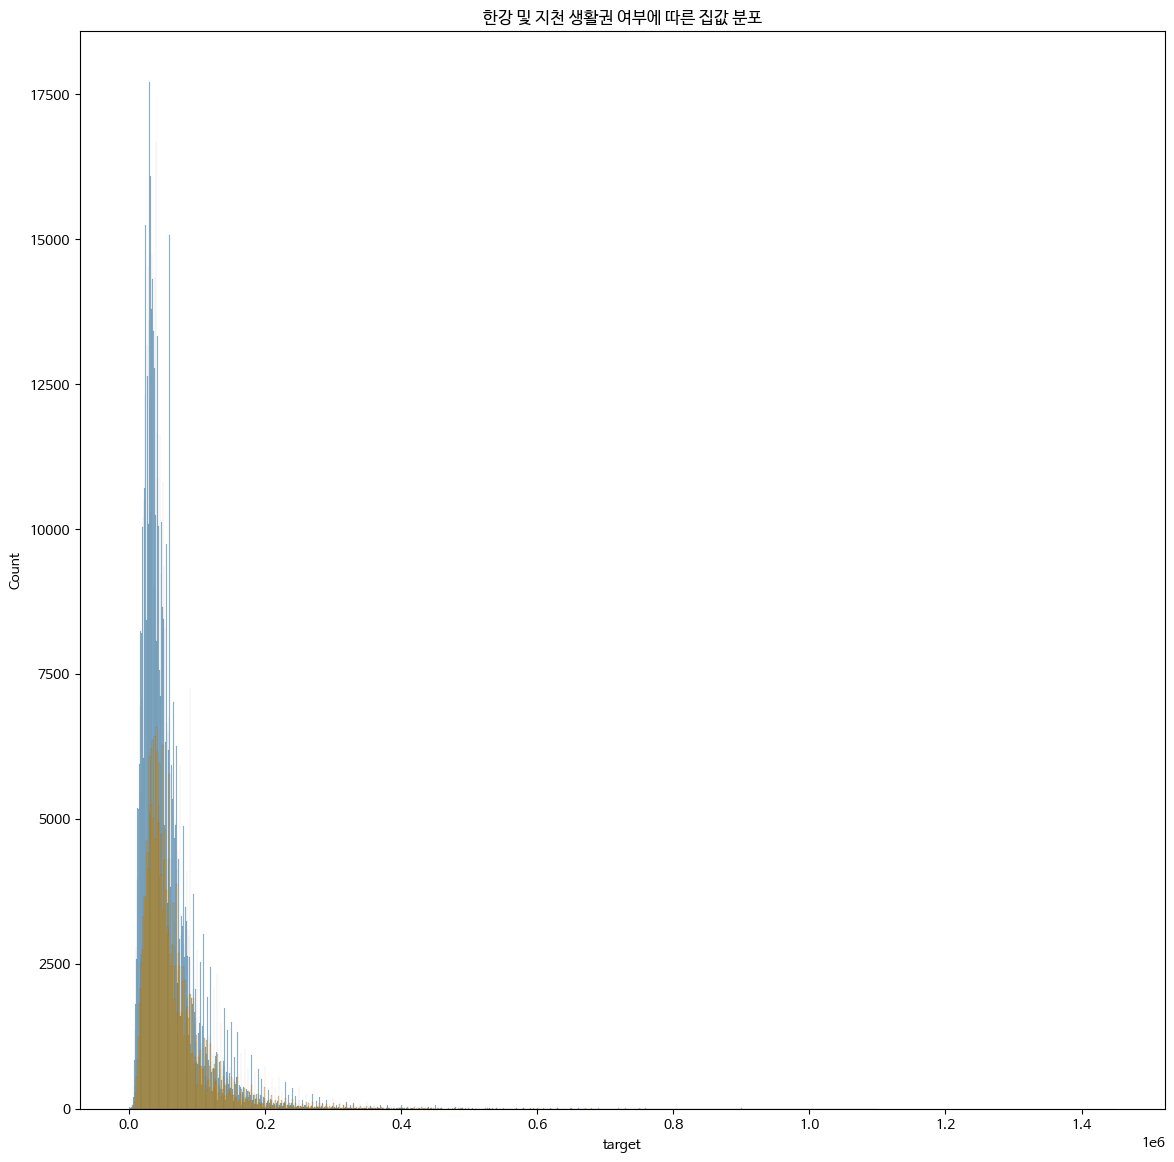

In [26]:
plt.figure(figsize=(14,14))
sns.histplot(data=not_near_hangang_a, x='target', alpha=0.5)
sns.histplot(data=near_hangang_a, x='target', color='orange', alpha=0.5)
plt.title("한강 및 지천 생활권 여부에 따른 집값 분포")
plt.show()